# Chapter 4: Generative Adversarial Networks

## Wasserstein GAN

As mentioned in `GenerativeAdversarialNetworks.ipynb`, Training GANs can be difficult because of the lack of a meaningful loss metric. [_Wasserstein GAN_](https://arxiv.org/pdf/1701.07875.pdf) (WGAN) is a GAN model that tries to solve this problem by introducing a new loss metric, the _Wasserstein loss_.

When comparing predictions made by a model, $p_i$, to actual observations, $y_i$, recall that the _binary crossentropy_ is given by

$$ -\frac{1}{n} \sum\limits_{i\,=\,1}^n \bigg( y_i \log p_i + \left(1 - y_i\right) \log\left(1-p_i\right) \bigg). $$

To train the discriminator, $D$, we compare the predictions $p_i = D(x_i) $ with the response $y_i = 1$ for real images and $ p_i = D(G(z_i)) $ with the response $y_i = 0$ for the generated images. Therefore the discriminator's objective can be written as

$$ {\min}_D - \bigg( \mathbb{E}_{x\in X}\left[\log D(x)\right] - \mathbb{E}_{z\in Z}\left[ 1 - \log D(G(z)) \right] \bigg) $$

where $X$ is the set of observations used in each training iteration and $Z$ is a set of random inputs for the generator, $G$. The generator's objective can be similarly written as

$$ {\min}_G - \mathbb{E}_{z\in Z} \left[ \log D(G(z)) \right] $$

where $Z$ is a set of inputs of random noise for the generator. The Wasserstein loss instead requires that the labels for generated samples be -1 instead of zero. The output of the discriminator, now called the _critic_, also no longer has a sigmoid activation function, so it's output's range becomes $(-\infty, \infty)$. The Wasserstein loss function is given by

$$ -\frac{1}{n}\sum\limits_{i\,=\,1}^n \big(y_i p_i\big). $$

Using this new loss function, we can rewrite the objective of the critic to be

$$ {\min}_D - \bigg( \mathbb{E}_{x\in X} \left[D(x)\right] - \mathbb{E}_{z\in Z} \left[ D(G(z)) \right] \bigg) $$

i.e. the critic wants to maximize the difference between the predicted values for real samples and generated samples. The generator's objective is now

$$ {\min}_G -\mathbb{E}_{z\in Z} \left[ D(G(z)) \right] $$

i.e. it wants to maximize the critic's prediction for each generated sample.

### The Lipschitz Constraint

One potential problem with using the Wesserstein loss function is that the weights of the critic can grow very large. In order for the Wesserstein function to work, it is required that the critic is a _1-Lipschitz continuous function_, i.e. for any two samples $x_1$ and $x_2$ the following inequality holds

$$ \frac{|D(x_1) - D(x_2)|}{|x_1 - x_2|} \leq 1 $$

where $D(x_i)$ is the critic's prediction of $x_i$ and $x_2 - x_1$ is the average pixelwise difference between the two samples. You can find a more detailed explanation about why we need this constraint [here](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490).

One way that we can enforce this constraint is by using _weight clipping_, i.e. by setting a maximum and minimum threshold of values the weights of the critic can take.

## Implementing a WGAN

Below is code for a class that implements a WGAN. We will later use this model to generate images that look like they are from the CIFAR-10 dataset.

In [0]:
!pip install -U tensorflow-gpu

In [0]:
# Mount Google drive to load the data and to save the model weights.
from google.colab import drive

drive.mount('/content/gdrive/')
checkpoint_path = '/content/gdrive/My Drive/gdl_models/wgan/'

In [0]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization,
                                     LeakyReLU, Activation, Dropout, Flatten,
                                     Dense, Reshape, UpSampling2D,
                                     Conv2DTranspose)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt


def get_activation(activation_fn_name):
  """Get the activation layer from the name of the function."""
  if activation_fn_name == 'leaky_relu':
    return LeakyReLU(alpha=0.2)
  return Activation(activation_fn_name)


def wasserstein_loss(y_true, y_pred):
  """Wasserstein loss function."""
  return -K.mean(y_true * y_pred)


def get_optimizer(optimizer_name, learning_rate):
  """Get an optimizer by name."""
  if optimizer_name == 'adam':
    return Adam(lr=learning_rate)
  if optimizer_name == 'rmsprop':
    return RMSprop(lr=learning_rate)
  return Adam(lr=learning_rate)


def set_trainable(model, value):
  """Set each layer of a model as trainable."""
  model.trainable = value
  for l in model.layers:
    l.trainable = value


class WGAN(object):
  """Implementation of a Wasserstein GAN."""

  def __init__(self, input_shape, critic_conv_filters, critic_conv_kernel_size,
               critic_conv_strides, critic_batch_norm_momentum,
               critic_activation, critic_dropout_rate, critic_learning_rate,
               generator_initial_dense_layer_size, generator_upsample,
               generator_conv_filters, generator_conv_kernel_size,
               generator_conv_strides, generator_batch_norm_momentum,
               generator_activation, generator_dropout_rate,
               generator_learning_rate, optimizer, z_dim):
    critic_input = Input(shape=input_shape, name='critic_input')
    x = critic_input
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    for i in range(len(critic_conv_filters)):
      x = Conv2D(filters=critic_conv_filters[i],
                 kernel_size=critic_conv_kernel_size[i],
                 strides=critic_conv_strides[i], padding='same',
                 kernel_initializer=weight_init,
                 name='critic_conv_{}'.format(i))(x)
      if critic_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum=critic_batch_norm_momentum)(x)
      x = get_activation(critic_activation)(x)
      if critic_dropout_rate:
        x = Dropout(rate=critic_dropout_rate)(x)
    x = Flatten()(x)
    critic_output = Dense(1, activation=None, name='critic_output')(x)
    self.critic = Model(critic_input, critic_output)

    self.z_dim = z_dim

    generator_input = Input(shape=(self.z_dim,), name='generator_input')
    x = generator_input
    x = Dense(np.prod(generator_initial_dense_layer_size),
              kernel_initializer=weight_init)(x)
    if generator_batch_norm_momentum:
      x = BatchNormalization(momentum=generator_batch_norm_momentum)(x)
    x = get_activation(generator_activation)(x)
    x = Reshape(generator_initial_dense_layer_size)(x)
    if generator_dropout_rate:
      x = Dropout(rate=generator_dropout_rate)(x)
    for i in range(len(generator_conv_filters)):
      if generator_upsample[i] == 2:
        x = UpSampling2D()(x)
        x = Conv2D(filters=generator_conv_filters[i],
                   kernel_size=generator_conv_kernel_size[i],
                   strides=generator_conv_strides[i], padding='same',
                   name='generator_conv_{}'.format(i))(x)
      else:
        x = Conv2DTranspose(filters=generator_conv_filters[i],
                            kernel_size=generator_conv_kernel_size[i],
                            strides=generator_conv_strides[i], padding='same',
                            kernel_initializer=weight_init,
                            name='generator_conv_{}'.format(i))(x)
      if i < (len(generator_conv_filters) - 1):
        if generator_batch_norm_momentum:
          x = BatchNormalization(momentum=generator_batch_norm_momentum)(x)
        x = get_activation(generator_activation)(x)
        if generator_dropout_rate:
          x = Dropout(rate=generator_dropout_rate)(x)
      else:
        x = Activation('tanh')(x)
    generator_output = x
    self.generator = Model(generator_input, generator_output)

    self.critic.compile(
        optimizer=get_optimizer(optimizer, critic_learning_rate),
        loss=wasserstein_loss)
    
    set_trainable(self.critic, False)

    model_input = Input(shape=(self.z_dim,), name='model_input')
    model_output = self.critic(self.generator(model_input))
    self.model = Model(model_input, model_output)
    self.model.compile(
        optimizer=get_optimizer(optimizer, generator_learning_rate),
        loss=wasserstein_loss)

    set_trainable(self.critic, True)

  def train_critic(self, X_train, batch_size, clip_threshold):
    """Train the critic model."""
    real = np.ones(shape=(batch_size, 1))
    fake = -np.ones(shape=(batch_size, 1))

    idx = np.random.randint(0, len(X_train), size=(batch_size,))
    X_real = X_train[idx]

    noise = np.random.normal(size=(batch_size, self.z_dim))
    X_fake = self.generator.predict(noise)

    d_loss_real = self.critic.train_on_batch(X_real, real)
    d_loss_fake = self.critic.train_on_batch(X_fake, fake)
    d_loss = (d_loss_real + d_loss_fake) / 2.0

    for l in self.critic.layers:
      weights = self.critic.get_weights()
      self.critic.set_weights(
          [np.clip(w, -clip_threshold, clip_threshold) for w in weights])
      
    return d_loss

  def train_generator(self, batch_size):
    """Train the generator to trick the critic."""
    real = np.ones(shape=(batch_size, 1))
    noise = np.random.normal(size=(batch_size, self.z_dim))
    return self.model.train_on_batch(noise, real)

  def train(self, X_train, batch_size, epochs, n_critic, print_every_n_epochs,
            save_every_n_epochs, clip_threshold=0.01, checkpoint_path=None,
            initial_epoch=0):
    """Train the WGAN."""
    if initial_epoch > 0 and checkpoint_path:
      self.model.load_weights(
          checkpoint_path + 'model_weights_{}.hdf5'.format(initial_epoch))
    for epoch in range(initial_epoch + 1, epochs + 1):
      for _ in range(n_critic):
        d_loss = self.train_critic(X_train, batch_size, clip_threshold)
      g_loss = self.train_generator(batch_size)
      if epoch % print_every_n_epochs == 0:
        print('Epoch: {}'.format(epoch))
        print('D Loss: {:04f}'.format(d_loss))
        print('G Loss: {:04f}'.format(g_loss))
      if epoch % save_every_n_epochs == 0 and checkpoint_path:
        print('Saving after epoch: {}'.format(epoch))
        self.model.save_weights(checkpoint_path + 'model_weights.hdf5')
        self.model.save_weights(
            checkpoint_path + 'model_weights_{}.hdf5'.format(epoch))

In [0]:
wgan = WGAN(input_shape=(32, 32, 3),
            critic_conv_filters=(32, 64, 128, 128),
            critic_conv_kernel_size=(5, 5, 5, 5),
            critic_conv_strides=(2, 2, 2, 1),
            critic_batch_norm_momentum=None,
            critic_activation='leaky_relu',
            critic_dropout_rate=None,
            critic_learning_rate=0.00005,
            generator_initial_dense_layer_size=(4, 4, 128),
            generator_upsample=(2, 2, 2, 1),
            generator_conv_filters=(128, 64, 32, 3),
            generator_conv_kernel_size=(5, 5, 5, 5),
            generator_conv_strides=(1, 1, 1, 1),
            generator_batch_norm_momentum=0.8,
            generator_activation='relu',
            generator_dropout_rate=None,
            generator_learning_rate=0.00005,
            optimizer='rmsprop',
            z_dim=100)

In [20]:
wgan.critic.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 4, 4, 128)         0  

In [21]:
wgan.generator.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_24 (Batc (None, 2048)              8192      
_________________________________________________________________
activation_48 (Activation)   (None, 2048)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 8, 8, 128)         409

### Downloading the Data

In [0]:
from keras.datasets import cifar10

(X_train_unscaled, y_train), (X_test_unscaled, y_test) = cifar10.load_data()

In [0]:
X_train_all = X_train_unscaled / 255.0
X_test_all = X_test_unscaled / 255.0

In [0]:
# Get the 6000 original images of horses from the dataset.

HORSE_LABEL = 7

X_train_orig = np.concatenate([X_train_all[y_train.squeeze() == HORSE_LABEL],
                               X_test_all[y_test.squeeze() == HORSE_LABEL]],
                              axis=0)

In [0]:
# Double the size of the training set by flipping each image horizontally.

X_train = np.concatenate([X_train_orig, np.flip(X_train_orig, axis=2)], axis=0)

Plot some of the images in the test set to see what we are trying to have the model generate.

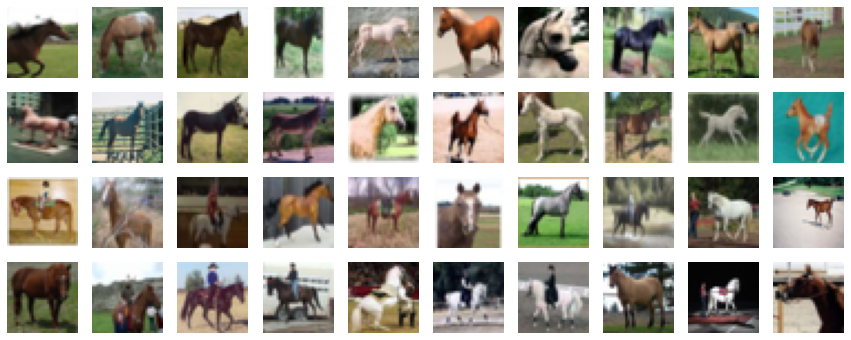

In [69]:
fig = plt.figure(figsize=(15, 6))
n_to_show = 40
n_rows = 4

for i in range(n_to_show):
  ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
  ax.axis('off')
  ax.imshow(X_train[np.random.randint(0, len(X_train))].squeeze())

## Training the WGAN

Below we train the WGAN to create its own pictures of horses with the 12,000 images we compiled.

In [0]:
wgan.train(X_train, batch_size=128, epochs=6000, n_critic=5,
           print_every_n_epochs=10, save_every_n_epochs=100,
           clip_threshold=0.01, checkpoint_path=checkpoint_path,
           initial_epoch=0)

Epoch: 10
D Loss: -0.018551
G Loss: 0.025813


In [0]:
fig = plt.figure(figsize=(15, 6))
n_to_show = 10
n_rows = 1

for i in range(n_to_show):
  ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
  ax.axis('off')
  ax.imshow(wgan.generator.predict(np.random.normal(size=(1, wgan.z_dim)))[0])